In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from matplotlib import colors
import math
import colorsys

Funkcje do zaimplementowania:

In [2]:
# konwerter: nie trzeba implementować samemu, można wykorzystać funkcję z bilbioteki
def hsv2rgb(h, s, v):
    return colorsys.hsv_to_rgb(h, s, v)

# poniżej znajdują się funkcje modelujące kolejne gradienty z zadania.
# v to pozycja na osi ox: v jest od 0 do 1. Zewnetrzna funkcja wywołuje te metody podając
# różne v i oczekując trójki RGB bądź HSV reprezentującej kolor. Np. (0,0,0) w RGB to kolor czarny.
# Należy uwikłać v w funkcję modelującą kolor. W tym celu dla kolejnych gradientów trzeba przyjąć
# sobie jakieś punkty charakterystyczne,
# np. widzimy, że po lewej stronie (dla v = 0) powinien być kolor zielony a w środku niebieski (dla v = 0.5),
# a wszystkie punkty pomiędzy należy interpolować liniowo (proporcjonalnie).

# Return mixed color for certain v
# Example - assume that len(colors) = 5 and v = 0.28


def lerp(a, b, v):
    '''
    Linearly interpolate between a and b, in base on v.
    '''
    return ((1 - v) * a) + (v * b)


def getColor(colors, v):
    # Every color is a point in spectrum, so we have N - 1 sections between colors.
    step = 1.0 / (len(colors) - 1)
    # Calculate index of first color.
    section = int((v - 0.0001) / step)
    # Value have to be rescaled proportionally to `step`
    v = (v % step) / step

    return tuple([lerp(x, y, v) for x, y in zip(colors[section], colors[section + 1])])


def gradient_rgb_bw(v):
    return getColor(((0, 0, 0), (1, 1, 1)), v)


def gradient_rgb_gbr(v):
    return getColor(((0, 1, 0), (0, 0, 1), (1, 0, 0)), v)


def gradient_rgb_gbr_full(v):
    return getColor(((0, 1, 0), (0, 1, 1), (0, 0, 1), (1, 0, 1), (1, 0, 0)), v)


def gradient_rgb_wb_custom(v):
    return getColor(((1, 1, 1), (1, 0, 1), (0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0), (0, 0, 0)), v)


def gradient_hsv_bw(v):
    hsv = getColor(((1, 0, 0), (0, 0, 1)), v)
    return hsv2rgb(*hsv)


def gradient_hsv_gbr(v):
    hsv = getColor(((1/3, 1, 1), (2/3, 1, 1), (1, 1, 1)), v)
    return hsv2rgb(*hsv)


def gradient_hsv_unknown(v):
    hsv = getColor(((1/3, 0.502, 1), (0, 0.502, 1)), v)
    return hsv2rgb(*hsv)


def gradient_hsv_custom(v):
    hsv = getColor(((0, 1, 1), (1/3, 1, 1), (2/3, 0.5, 1), (1, 0, 1)), v)
    return hsv2rgb(*hsv)


In [3]:
def plot_color_gradients(gradients, names):
    # For pretty latex fonts (commented out, because it does not work on some machines)
    rc('text', usetex=True) 
    rc('font', family='serif', serif=['Times'], size=10)
    rc('legend', fontsize=10)

    column_width_pt = 400         # Show in latex using \the\linewidth
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch

    fig, axes = plt.subplots(nrows=len(gradients), sharex=True, figsize=(size, 0.75 * size))
    fig.subplots_adjust(top=1.00, bottom=0.05, left=0.25, right=0.95)


    for ax, gradient, name in zip(axes, gradients, names):
        # Create image with two lines and draw gradient on it
        img = np.zeros((2, 1024, 3))
        for i, v in enumerate(np.linspace(0, 1, 1024)):
            img[:, i] = gradient(v)

        im = ax.imshow(img, aspect='auto')
        im.set_extent([0, 1, 0, 1])
        ax.yaxis.set_visible(False)

        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.25
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='left', fontsize=10)

    fig.savefig('my-gradients.pdf')

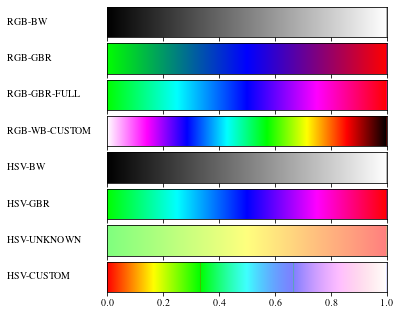

In [4]:
def toname(g):
    return g.__name__.replace('gradient_', '').replace('_', '-').upper()
    
gradients = (gradient_rgb_bw, gradient_rgb_gbr, gradient_rgb_gbr_full, gradient_rgb_wb_custom,
                 gradient_hsv_bw, gradient_hsv_gbr, gradient_hsv_unknown, gradient_hsv_custom)

plot_color_gradients(gradients, [toname(g) for g in gradients])

In [5]:
import numpy as np

def normalize(vec: np.array):
    magnitude = np.sqrt(np.sum(vec**2))
    if magnitude == 0:
        return np.array([0 for _ in vec])
    return np.array([v / magnitude for v in vec])


class Vertex:
    def __init__(self, position: np.array, normal: np.array):
        self.position = position
        self.normal = normal / np.linalg.norm(normal)

    def set_light(self, src: np.array):
        light = src - self.position
        self.light = light / np.linalg.norm(light)

    def get_color(self, color, intensity = 1):
        coeff = np.clip(np.dot(self.normal, self.light) * intensity, 0, 255)
        return tuple([int(v * coeff) for v in color])

In [6]:
from itertools import chain


class Map:
    def __init__(self, width, height, scale, values):
        self.width = width
        self.height = height
        self.scale = scale
        self.rows: list[list[Vertex]] = values

    @staticmethod
    def _normalize_(matrix) -> list[list[float]]:
        '''
        *** PRIVATE METHOD ***

        Normalizes given matrix so all values are between 0.0 and 1.0
        '''
        # To normalize values we need minimal and maximal value present in matrix.
        #
        # Uniformization follows the following transformations:
        # x - height
        # x' - normalized height
        # min - minimal value present in matrix (offset)
        # max - maximal value after offset application (maximal value present in matrix + offset)
        # x' = (x + min) / max
        min_val = min([min(row) for row in matrix])
        max_val = max([max(row) for row in matrix]) - min_val

        values = []
        for row in matrix:
            uniform_row = [(value - min_val) / max_val for value in row]
            values.append(uniform_row)

        return values

    @staticmethod
    def _normal_(row, column, matrix) -> np.array:
        self = matrix[row][column]
        # Strategy for neighbor choose:
        #
        # If we're in first row then vertical neighbor is from bottom row
        # otherwise vertical neighbor is from top row.
        #
        # If we're in first column then horizontal neighbor is from right column
        # otherwise horizontal neighbor is from left column.
        if row != 0:
            first = matrix[row - 1][column]
        else:
            first = matrix[1][column]

        if column != 0:
            second = matrix[row][column - 1]
        else:
            second = matrix[row][1]

        first = first - self
        second = second - self

        return np.cross(second, first)

    @classmethod
    def from_file(self, filename):
        with open(filename) as src:
            width, height, scale = [int(value) for value in src.readline().split()]
            matrix = []
            for row in src:
                row = [float(value) for value in row.split()]
                matrix.append(row)
        # matrix = self._normalize_(matrix)

        # Create matrix of positions in form [x, y, z]
        normalized = self._normalize_(matrix)
        normals = []
        positions = []
        for row in range(height):
            normals_row = [np.array([float(column), float(row), matrix[row][column]])
                   for column in range(width)]
            row = [np.array([float(column), float(row), normalized[row][column]])
                   for column in range(width)]
            positions.append(row)
            normals.append(normals_row)

        # Create matrix of vertices with positions and normals

        matrix = []
        for _row_ in range(height):
            row = []
            for _column_ in range(width):
                normal = self._normal_(_row_, _column_, normals)
                vertex = Vertex(positions[_row_][_column_], normal)
                row.append(vertex)
            matrix.append(row)

        return self(width, height, scale, matrix)

    def render(self, color_fn, light: np.array = None) -> list:
        rendered = []
        for value in chain(*self.rows):
            color = color_fn(value.position[2])
            if light is not None:
                value.set_light(light)
                rendered.append([*value.get_color(color)])
            else:
                rendered.append([*color])

        return chain(*rendered)


In [7]:
_map = Map.from_file("big.dem")

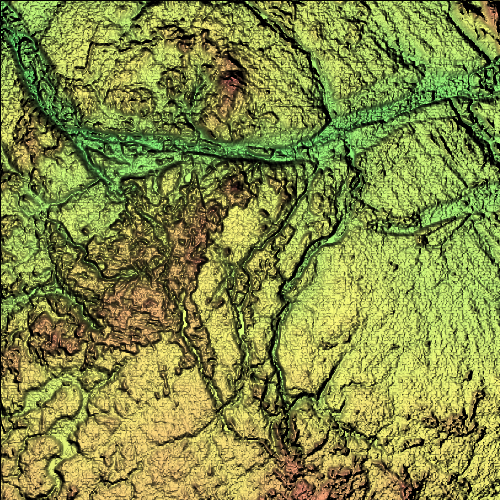

In [18]:
from IPython.display import display
from PIL import Image

def mono(value: float):
    v = int(value * 255)
    return (v, v, v)

def gradient(value: float):
    r, g, b = gradient_hsv_unknown(value)
    return (int(r * 255), int(g * 255), int(b * 255))

LIGHT = np.array([150, 250, 700])
buffer = _map.render(gradient, LIGHT)

img = Image.frombytes("RGB", (_map.width, _map.height), bytes(buffer))
display(img)